# MISC NOTES:
- I'm not stratifying rn because it's equal win/loss, but we can try that if things look bad

# Introduction

## Motivation and Background

Hockey predictions have become a hot topic in recent years. Hockey fans praise hockey's unpredictability, citing how exciting it is to know that any team has a chance. This is usually contrasted with sports like basketball, where it is rare to for underdogs to win. [Here is a video](https://www.youtube.com/watch?v=c4fFOu8nyeM) of former NBA star and current NBA commentator Charles Barkley talking about why he enjoys hockey playoffs, saying that "you have no idea who is going to win." Vox put out [a video](https://www.youtube.com/watch?v=HNlgISa9Giw) on this phenomenon as well, claiming that the reason that hockey underdogs do better than basketball is due to a higher luck element in hockey. 

But is hockey really so difficult to predict? Compared to other sports, hockey analytics are minimal. The few hockey betting sites that exist use extremely simple algorithms to predict which team will win, and often get it wrong. There is very little other published work about hockey analysis, mostly results from other projects with varying success. Either teams and other groups are not using complex analytics, or they do not want to publish their work publicly. 

Aside from leveraging models to aid in sports betting and playoff predictions, having an accurate prediction tool can be useful for teams in post-game analysis. Models can highlight patterns to success or failure that might not be obvious when looking only at raw statistics.

Our project will attempt to answer whether hockey is a difficult sport to predict. We will use multiple modeling techniques and select the best model to predict the result of hockey games.


## Data Source and Description

Our data comes from the [NHL Game Dataset](https://www.kaggle.com/datasets/martinellis/nhl-game-data) on Kaggle. The dataset was uploaded by Martin Ellis and most recently updated a year ago. The dataset contains data pulled from NHL.com. 

The dataset is incredibly robust, and contains multiple .csv files full of data on players, coaches, teams, and games. For our project, we will only be using three of these files, games.csv, game_teams_stats.csv, and team_info.csv. Games.csv contains information about he games that happened, game_teams_stats.csv contains information about the teams that played in those games, and team_info.csv is the connecting set for these two files. 



## NHL and Hockey Terms

The NHL contains now 32 teams in the US and Canada, though our project will only include data on 31 of these teams, as the Seattle Kraken only joined the league in 2022. It is also important to note that some of these teams have moved, disbanded, or been created throughout the years. For example, the Atlanta Thrashers moved to Winnipeg and became the Jets in 2011. Teams that moved to a new location will be treated as different teams. 

NHL teams play 82 games in the regular season, barring any lockouts, COVID related delays, or other issues. 16 teams qualify for the playoffs and play in a four-round, single elimination bracket. Our analysis will include both playoff and regular season games, and will not differentiate between the two. 

Our analysis will contain many variables to help predict the outcome of games. Some hockey terms that are helpful to know include the following:

- Shots - Shots in hockey are defined as shots on goal that the goalie saves.

- Hits - A hit is when a player removes an opposing player from the puck, usually by running into them.

- PIM - Stands for penalties in minutes. Players who receive a penalty usually go to the penalty box for a designated period of time.

- Powerplay - When one team gets a penalty the other team will get to play with more players on the ice than them, as one or more of their players are in the penalty box. This is called a powerplay. 

- Faceoff - When the referee drops the puck to start a play, and two players compete to win possession of it. 

- Giveaway - When a player's own actions result in the loss of the puck

- Takeaway - When a player's actions on the team without the puck result in them taking the puck from a player on the team with it. 

- Points - A hockey team earns 2 points for a win, 0 points for a loss, and 1 point for a loss in overtime or a shootout.

- Point Percentage - Points/(Games Played * 2)

## Project Goal

The goal of this project is to create a model that can successfully predict the winner of NHL games better statistically better than 50% accuracy. (Once we get the number of games we are predicting on we can do a 99% confidence interval for better than 50%). 

# Notebook Configuration

Copied over the usual setup, though we may want to change some later. I dont think we need the google drive setup if are just importing from clolab so ill remove it for now.

## Warning

In [1]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## Random seed

In [3]:
# The random seed
random_seed = 42

# Set random seed in tensorflow
#tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

# Data Preprocessing

## Importing

We took the data initially hosted on Kaggle and moved it to Github to make it easier to import.

In [4]:
import pandas as pd

game = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/game.csv')
team_stats = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/game_teams_stats.csv')
team_info = pd.read_csv('https://raw.githubusercontent.com/adamkritz/nhlgames/main/Data/team_info.csv')

## Initial Feature Selection and Cleaning

Games were included only if they were official games (Regular Season or Playoffs) and if they had an official outcome (settled in Regulation or Overtime).

In [5]:
game = game[game['type'].isin(['R','P'])]
team_stats = team_stats[team_stats['settled_in'].isin(['REG', 'OT'])]
datgame = game[['game_id', 'season', 'date_time_GMT']]
datteam = team_stats[['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'shots', 'hits', 'pim', 'powerPlayOpportunities', 'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked']]

dat = datteam.merge(datgame, on = 'game_id', how = 'inner')
dat = dat.drop_duplicates(subset = ['game_id', 'team_id'])

dat = dat.sort_values(by = ['team_id', 'date_time_GMT'])
dat['date_time_GMT'] = pd.to_datetime(dat['date_time_GMT'])

## Feature Engineering

**created features**:
- points: The points recieved by the team for this game. 2 for a win, 1 for a loss in overtime, and 0 for a regulation loss
- last season points percentage: The points percentage (revieved points / total possible points) of the previous season.
- running points percentag: The points percentage of the team up to that point in the season, before going into the game in question.
- last 10 points percentage: The points percentage of the last 10 games of the current season.

In [6]:
dat['pts'] = dat.apply(lambda x: 2 if x.won else 1 if not x.won and x.settled_in == 'OT' else 0, axis = 1)

In [7]:
seasonsorted = sorted(dat['season'].unique())
dat['season_num'] = dat['season'].apply(lambda x: seasonsorted.index(x))
grouped = dat.groupby(['team_id', 'season_num']).agg({'game_id':'count', 'pts':'sum'})
grouped = grouped.reset_index()
grouped['pts_perc_last_szn'] = grouped['pts']/(grouped['game_id']*2)
grouped['season_num'] = grouped['season_num']+1

to_merge = grouped[['team_id', 'season_num', 'pts_perc_last_szn']]
dat = dat.merge(to_merge, on = ['season_num', 'team_id'], how = 'left')

In [8]:
dat['L10_pts_perc'] = dat.groupby(['team_id', 'season_num'])['pts'].transform(lambda x: x.rolling(10,10).sum()/20)
dat['rolling_pts%'] = dat.groupby(['team_id', 'season_num']).apply(lambda x: x.pts.expanding().sum()/(x.pts.expanding().count()*2)).values

## Transformations

- The 'home' value was transformed from 'H' (home) and 'A' (away) to a binary value where 1 is home and 0 is away.
- The time stamp of the game was transformed into total seconds (unix time)
- The head coach column became the running points percentage of the coach until that point, spanning their entire career and all teams.
- 'Won' column from binary to 0 and 1

In [9]:
dat['home'] = dat['HoA'].apply(lambda x: 1 if x=='home' else 0)

In [10]:
dat['gametime_unix'] = dat['date_time_GMT'].apply(lambda x: x.timestamp())

In [11]:
coach_group = dat.groupby(['head_coach']).apply(lambda x: x.won.expanding().sum()/(x.won.expanding().count()*2))
coach_flat = coach_group.reset_index().rename(columns = {'won':'coach_pts%'})
dat = dat.merge(coach_flat, left_index=True, right_on = 'level_1')


In [12]:
dat['won'] = dat['won'].astype(int)

## Remove Unecessary Columns

In [13]:
df = dat.drop(['HoA', 'head_coach_x', 'date_time_GMT', 'season', 'head_coach_y', 'level_1', 'settled_in', 'pts'], axis = 1)

## Splitting Data

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size = 0.8, random_state = random_seed)

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.8, random_state=random_seed)

# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

target = 'won'

In [15]:
# getting the shape of the data

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)
print('Val shape: ', df_val.shape)

Train shape:  (30356, 18)
Test shape:  (9487, 18)
Val shape:  (7589, 18)


In [16]:
df_train.head()

,game_id,team_id,won,shots,hits,pim,powerPlayOpportunities,faceOffWinPercentage,giveaways,takeaways,blocked,season_num,pts_perc_last_szn,L10_pts_perc,rolling_pts%,home,gametime_unix,coach_pts%
0,2013020093,9,1,32.0,27.0,8.0,3.0,44.4,4.0,1.0,10.0,12,0.568966,NaN,0.500000,0,1.381889e+09,0.248366
1,2002020974,21,1,29.0,11.0,12.0,5.0,NaN,7.0,1.0,18.0,2,0.603659,0.80,0.630769,0,1.046653e+09,0.323529
2,2007021052,2,0,24.0,19.0,15.0,4.0,NaN,9.0,7.0,6.0,6,0.560976,0.30,0.500000,0,1.205278e+09,0.233553
3,2018020302,28,1,29.0,23.0,2.0,2.0,53.3,9.0,7.0,18.0,17,0.614130,0.55,0.595238,1,1.542512e+09,0.243030
4,2003020755,16,0,20.0,11.0,17.0,6.0,NaN,6.0,5.0,6.0,3,0.481707,0.25,0.352941,0,1.075259e+09,0.193023


In [17]:
df_test.head()

,game_id,team_id,won,shots,hits,pim,powerPlayOpportunities,faceOffWinPercentage,giveaways,takeaways,blocked,season_num,pts_perc_last_szn,L10_pts_perc,rolling_pts%,home,gametime_unix,coach_pts%
34719,2000020121,10,1,29.0,NaN,15.0,5.0,NaN,NaN,NaN,NaN,0,NaN,NaN,0.625000,1,9.725166e+08,0.312500
25650,2016020278,29,0,42.0,9.0,2.0,1.0,53.1,10.0,9.0,14.0,15,0.463415,0.80,0.676471,1,1.479773e+09,0.238454
14822,2010020834,27,1,25.0,22.0,8.0,3.0,58.6,2.0,5.0,8.0,9,0.652439,0.60,0.587719,1,1.297559e+09,0.274788
29360,2011021097,7,1,31.0,9.0,11.0,6.0,51.7,3.0,10.0,11.0,10,0.578652,0.70,0.540541,1,1.332371e+09,0.253052
37568,2015030415,28,1,22.0,30.0,8.0,2.0,51.4,2.0,5.0,17.0,14,0.542683,0.65,0.619048,0,1.465517e+09,0.233547


## Checking Features

### Uncommon Features

In [18]:
## getting common features
common_features = np.intersect1d(np.intersect1d(df_train.columns, df_val.columns), df_test.columns)
print(common_features)

['L10_pts_perc' 'blocked' 'coach_pts%' 'faceOffWinPercentage' 'game_id'
 'gametime_unix' 'giveaways' 'hits' 'home' 'pim' 'powerPlayOpportunities'
 'pts_perc_last_szn' 'rolling_pts%' 'season_num' 'shots' 'takeaways'
 'team_id' 'won']


In [19]:
uncommon = np.setdiff1d(df_train.columns, common_features) + np.setdiff1d(df_val.columns, common_features) + np.setdiff1d(df_test.columns, common_features)
print(uncommon)

[]


kewl, no uncommon features, probs didn't need this cause we saw they all had the same number of columns, ah well

### Identifiers

In [20]:
id_cols = ['game_id']

df_train.drop(columns = id_cols, inplace = True)
df_test.drop(columns = id_cols, inplace = True)
df_val.drop(columns = id_cols, inplace = True)

print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)
print('Val shape: ', df_val.shape)

Train shape:  (30356, 17)
Test shape:  (9487, 17)
Val shape:  (7589, 17)


## Missing Data

In [21]:
import copy
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)
edadf = copy.deepcopy(df)


In [22]:
def nan_checker(df):
    # JAMES'S CODE !! Just so i can use the func, figure out how to use this later
    """
    The NaN checker

    Parameters
    ----------
    df : the dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and data type
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and data type
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

In [23]:
df_miss = nan_checker(df)

# Print df_nan
df_miss

,var,proportion,dtype
0,faceOffWinPercentage,0.466773,float64
1,L10_pts_perc,0.108724,float64
2,hits,0.103727,float64
3,giveaways,0.103727,float64
4,takeaways,0.103727,float64
5,blocked,0.103727,float64
6,pts_perc_last_szn,0.057472,float64


All the missing data are floats so we can consider them missing and impute them

In [24]:
from sklearn.impute import SimpleImputer

# The SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Impute the variables with missing values in df_train, df_val and df_test 
df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

## Encoding

In [25]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Print the unique data type of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,int64
1,float64


No cat variables, woo, no need to encode

## Split Features and Target

In [26]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

## Scale

In [27]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

In [28]:
# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

# EDA
- The version of the dataframe used for EDA is the version right before imputing and scaling. So all the features are correctly formatted and in their original state, but there's no synthetic data.

In [36]:
import seaborn as sns
sns.set()
edadf = edadf.reset_index()

In [37]:
edadf.columns

Index(['index', 'team_id', 'won', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'faceOffWinPercentage', 'giveaways',
       'takeaways', 'blocked', 'season_num', 'pts_perc_last_szn',
       'L10_pts_perc', 'rolling_pts%', 'home', 'gametime_unix', 'coach_pts%'],
      dtype='object')

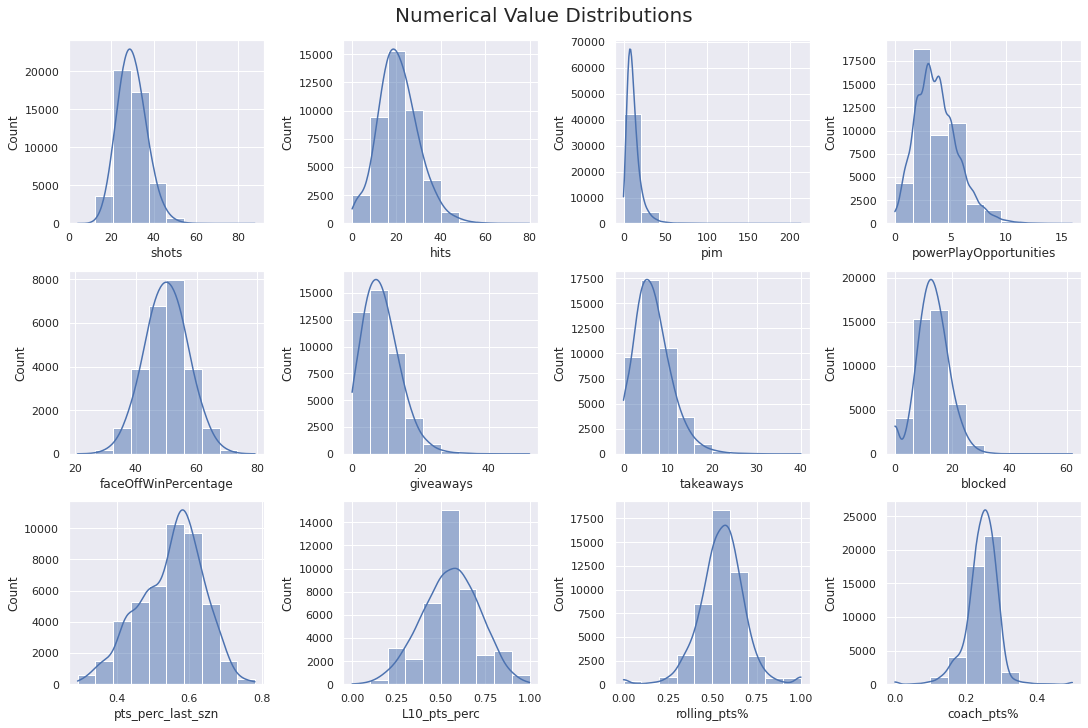

In [92]:
hist_features = ['shots', 'hits', 'pim', 'powerPlayOpportunities',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'blocked',
       'pts_perc_last_szn', 'L10_pts_perc', 'rolling_pts%',
       'coach_pts%']

nrows, ncols = 3, 4
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (15,10), constrained_layout = True)
count = 0
for row in axes:
  for ax in row:
    sns.histplot(data = edadf, x = hist_features[count], ax = ax, kde = True, bins = 10, kde_kws = {'bw_adjust':2})
    ax.set_xlabel(hist_features[count])
    count += 1

t = fig.suptitle('Numerical Value Distributions')

In [ ]:
games_won = edadf[edadf.won == 1]
g = sns.countplot(data = games_won, x = 'home')
g.axes.set_title('Number of Games Won At Home')

In [ ]:
season_17 = edadf[edadf.season_num == 17]
last_szn = season_17.groupby('team_id').mean().reset_index()[['team_id', 'pts_perc_last_szn']]
top_7 = last_szn.merge(team_info, on = 'team_id').sort_values(by = 'pts_perc_last_szn', ascending = False)[:7]
g = sns.barplot(data = top_7, y = 'teamName', x = 'pts_perc_last_szn')
g.axes.set_xlim((0.6, 0.7))
g.axes.set_title('Top 7 Pts% of the 2018-2019 Season')

I think this is a cool plot to include cause the bolts won the cup but the preds had the highest pts%

In [ ]:
g = sns.barplot(data = edadf, x = 'won', y = 'shots')
g.axes.set_ylim((25, 32))

In [ ]:
g = sns.barplot(data = edadf, x = 'won', y = 'hits')
g.axes.set_ylim((20,25))

In [ ]:
g = sns.barplot(data = edadf, x = 'won', y = 'pim')
g.axes.set_ylim((10,15))

# Training

This code was taken from: https://github.com/yuxiaohuang/teaching/blob/master/gwu/machine_learning_I/spring_2022/code/p2_shallow_learning/p2_c2_supervised_learning/p2_c2_s5_tree_based_models/case_study/case_study.ipynb 

These three models are a culmination of all the models we learned for classification. It has logistic regression, shallow neural networks, and random forest classifier (and als the histgradientboosting one). This was used to classify titanic survival as Yes or No, so it will probably be good for us.

## Creating the dictionary of the models
- In the dictionary:
    - the key is the acronym of the model
    - the value is the model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed)}

## Creating the dictionary of the pipelines
In the dictionary:
- the key is the acronym of the model
- the value is the pipeline, which, for now, only includes the model

In [ ]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

## Getting the predefined split cross-validator

Since we literally only use one utilities function, we can probably just create it here.

In [ ]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_val = np.vstack((X_train, X_val))

# Combine the target vector in the training and validation data
y_train_val = np.vstack((y_train.reshape(-1, 1), y_val.reshape(-1, 1))).reshape(-1)

# Get the indices of training and validation data
train_val_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_val.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_val_idxs)

## GridSearchCV

### Creating the dictionary of the parameter grids
- In the dictionary:
    - the key is the acronym of the model
    - the value is the parameter grid of the model

In [ ]:
param_grids = {}

#### The parameter grid for LogisticRegression
- The hyperparameters we want to fine-tune are:
    - tol
    - C
- See details of the meaning of the hyperparametes in [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [ ]:
# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 10]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

#### The parameter grid for MLPClassifier
- The hyperparameters we want to fine-tune are:
    - alpha
    - learning_rate_init

- See details of the meaning of the hyperparametes in [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [ ]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -2)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

#### The parameter grid for random forest
- The hyperparameters we want to fine-tune are:
    - min_samples_split
    - min_samples_leaf

- See details of the meaning of the hyperparametes in [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

#### The parameter grid for histogram-based gradient boosting
- The hyperparameters we want to fine-tune are:
- learning_rate
- min_samples_leaf

- See details of the meaning of the hyperparametes in [sklearn.ensemble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

In [ ]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

### Creating the directory for the cv results produced by GridSearchCV

In [ ]:
# Make directory
import os

directory = os.path.dirname(os.getcwd() + '/results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Tuning the hyperparameters
The code below shows how to fine-tune the hyperparameters of SGDRegressor and LinearRegression_MBGD using sklearn GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf=os.getcwd() + '/results/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.690598,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(alpha=1e-05, early_stopping=Tru..."
1,0.689108,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(random_state=42))
2,0.683033,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(max_features='auto', ..."
3,0.677906,"{'model__C': 0.1, 'model__tol': 1e-05}","(LogisticRegression(C=0.1, class_weight='balan..."


# Model Evaluation



## Getting the feature importance detected by random forest

In [ ]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[2]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((np.setdiff1d(df.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc.head()

,Features,Importance
0,L10_pts_perc,0.243753
1,rolling_pts%,0.203336
2,blocked,0.103285
3,coach_pts%,0.073008
4,hits,0.045387


## Plotting the Feature Importance

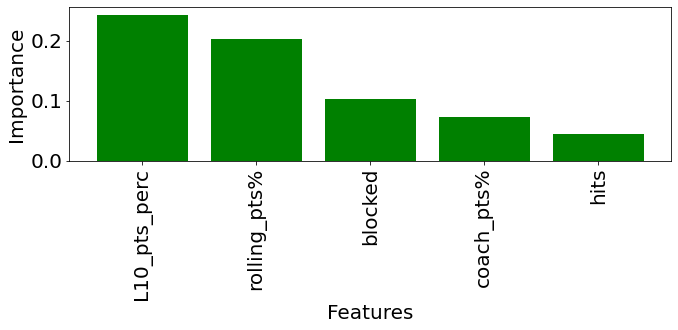

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:5], df_fi_rfc['Importance'][:5], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.show()

# Conclusion